# Jack's Car Rental Problem

## Problem definition

In [106]:
%matplotlib inline

In [107]:
!pip install scipy


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [108]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import sys

In [109]:
#Problem Parameters
class jcp:
    @staticmethod
    def max_cars():
        return 20
    
    @staticmethod
    def γ():
        return 0.9
    
    @staticmethod
    def credit_reward():
        return 10
    
    @staticmethod
    def moving_reward():
        return -2
    
    @staticmethod
    def parking_reward():
        return -4

In [110]:
class poisson_:
    
    def __init__(self, λ):
        self.λ = λ
        
        ε = 0.01
        
        # [α , β] is the range of n's for which the pmf value is above ε
        self.α = 0
        state = 1
        self.vals = {}
        summer = 0
        
        while(True):
            if state == 1:
                temp = poisson.pmf(self.α, self.λ) 
                if(temp <= ε):
                    self.α+=1
                else:
                    self.vals[self.α] = temp
                    summer += temp
                    self.β = self.α+1
                    state = 2
            elif state == 2:
                temp = poisson.pmf(self.β, self.λ)
                if(temp > ε):
                    self.vals[self.β] = temp
                    summer += temp
                    self.β+=1
                else:
                    break    
        
        # normalizing the pmf (probability mass function), values of n outside of [α, β] have pmf = 0
        
        added_val = (1-summer)/(self.β-self.α)
        for key in self.vals:
            self.vals[key] += added_val
        
            
    def f(self, n):
        try:
            Ret_value = self.vals[n]
        except(KeyError):
            Ret_value = 0
        finally:
            return Ret_value

In [111]:
# Poisson Distribution - examples
ex = poisson_(4)
print(ex.λ)
print(ex.α,ex.β)
print(ex.vals)

4
0 10
{0: np.float64(0.01912886316842758), 1: np.float64(0.07407577983463014), 2: np.float64(0.14733833538956684), 3: np.float64(0.19618003909285794), 4: np.float64(0.19618003909285794), 5: np.float64(0.1571066761302251), 6: np.float64(0.10500885884671443), 7: np.float64(0.0603535868894197), 8: np.float64(0.030583405584556547), 9: np.float64(0.014044415970743709)}


In [112]:
#A class holding the properties of a location together
class location:
    
    def __init__(self, req, ret):
        self.α = req                             #value of lambda for requests
        self.β = ret                             #value of lambda for returns
        self.poissonα = poisson_(self.α)
        self.poissonβ = poisson_(self.β)

In [113]:
#Location initialisation

A = location(3,3)
B = location(4,2)

In [114]:
#Initializing the value and policy matrices. Initial policy has zero value for all states.

value = np.zeros((jcp.max_cars()+1, jcp.max_cars()+1))
policy = value.copy().astype(int)

In [115]:
def apply_action(state, action):
    return [max(min(state[0] - action, jcp.max_cars()),0) , max(min(state[1] + action, jcp.max_cars()),0)]

In [116]:
# Test apply_action

print(apply_action([3,3], 2))
print(apply_action([3,3], 4))
print(apply_action([3,3], 3))

[1, 5]
[0, 7]
[0, 6]


## Expected Reward

Now we have two policies: one for the regular case and one with the non-linearities.

In [117]:
def expected_reward(state, action):
    global value
    """
    state  : It's a pair of integers, # of cars at A and at B
    action : # of cars transferred from A to B,  -5 <= action <= 5 
    """
    
    ψ = 0 #reward
    new_state = apply_action(state, action)
    
    # adding reward for moving cars from one location to another (which is negative) 
    
    ψ = ψ + jcp.moving_reward() * abs(action)
    
    #there are four discrete random variables which determine the probability distribution of the reward and next state
    
    for Aα in range(A.poissonα.α, A.poissonα.β):
        for Bα in range(B.poissonα.α, B.poissonα.β):
            for Aβ in range(A.poissonβ.α, A.poissonβ.β):
                for Bβ in range(B.poissonβ.α, B.poissonβ.β):
                    """
                    Aα : sample of cars requested at location A
                    Aβ : sample of cars returned at location A
                    Bα : sample of cars requested at location B
                    Bβ : sample of cars returned at location B
                    ζ  : probability of this event happening
                    """

                    # all four variables are independent of each other
                    ζ = A.poissonα.vals[Aα] * B.poissonα.vals[Bα] * A.poissonβ.vals[Aβ] * B.poissonβ.vals[Bβ]
                    
                    valid_requests_A = min(new_state[0], Aα)
                    valid_requests_B = min(new_state[1], Bα)
                    
                    rew = (valid_requests_A + valid_requests_B)*(jcp.credit_reward())
                    
                    #calculating the new state based on the values of the four random variables
                    new_s = [0,0]
                    new_s[0] = max(min(new_state[0] - valid_requests_A + Aβ, jcp.max_cars()),0)
                    new_s[1] = max(min(new_state[1] - valid_requests_B + Bβ, jcp.max_cars()),0)
                    
                    #Bellman's equation
                    ψ += ζ * (rew + jcp.γ() * value[new_s[0]][new_s[1]])
                    
    return ψ

In [118]:
def expected_reward_new(state, action):
    global value
    """
    state  : It's a pair of integers, # of cars at A and at B
    action : # of cars transferred from A to B,  -5 <= action <= 5 
    """
    
    ψ = 0 #reward
    new_state = apply_action(state, action)
    
    # adding reward for moving cars from one location to another (which is negative) 
    
    # One free move because the employee can move one car for free
    if action > 0:
        action -= 1
        
    
    ψ = ψ + jcp.moving_reward() * abs(action)
    
    #there are four discrete random variables which determine the probability distribution of the reward and next state
    
    for Aα in range(A.poissonα.α, A.poissonα.β):
        for Bα in range(B.poissonα.α, B.poissonα.β):
            for Aβ in range(A.poissonβ.α, A.poissonβ.β):
                for Bβ in range(B.poissonβ.α, B.poissonβ.β):
                    """
                    Aα : sample of cars requested at location A
                    Aβ : sample of cars returned at location A
                    Bα : sample of cars requested at location B
                    Bβ : sample of cars returned at location B
                    ζ  : probability of this event happening
                    """

                    # all four variables are independent of each other
                    ζ = A.poissonα.vals[Aα] * B.poissonα.vals[Bα] * A.poissonβ.vals[Aβ] * B.poissonβ.vals[Bβ]
                    
                    valid_requests_A = min(new_state[0], Aα)
                    valid_requests_B = min(new_state[1], Bα)
                    
                    rew = (valid_requests_A + valid_requests_B)*(jcp.credit_reward())
                    
                    #calculating the new state based on the values of the four random variables
                    new_s = [0,0]
                    new_s[0] = max(min(new_state[0] - valid_requests_A + Aβ, jcp.max_cars()),0)
                    new_s[1] = max(min(new_state[1] - valid_requests_B + Bβ, jcp.max_cars()),0)
                    
                    if new_s[0] > 10:
                        rew -= 4
                    if new_s[1] > 10:
                        rew -= 4
                    
                    #Bellman's equation
                    ψ += ζ * (rew + jcp.γ() * value[new_s[0]][new_s[1]])
                    
    return ψ

## Policy Evaluation

In [119]:
def policy_evaluation(reward_func):
    
    global value
    
    # here policy_evaluation has a static variable ε whose values decreases over time
    ε = policy_evaluation.ε
    
    policy_evaluation.ε /= 10 
    
    while(1):
        δ = 0
        
        for i in range(value.shape[0]):
            for j in range(value.shape[1]):
                # value[i][j] denotes the value of the state [i,j]
                
                old_val = value[i][j]
                value[i][j] = reward_func([i,j], policy[i][j])
                
                δ = max(δ, abs(value[i][j] - old_val))
                #print('.+\b', end = '')
                #sys.stdout.flush()
        print('\r'+'δ =',δ, end = '')
        #sys.stdout.flush()
    
        if δ < ε:
            break

In [120]:
#initial value of ε
policy_evaluation.ε = 50

## Policy Improvement

In [121]:
def policy_improvement(reward_func):
    
    global policy
    
    policy_stable = True
    for i in range(value.shape[0]):
        for j in range(value.shape[1]):
            old_action = policy[i][j]
            
            max_act_val = None
            max_act = None
            
            τ12 = min(i,5)       # if I have say 3 cars at the first location, then I can atmost move 3 from 1 to 2
            τ21 = -min(j,5)      # if I have say 2 cars at the second location, then I can atmost move 2 from 2 to 1
            
            for act in range(τ21,τ12+1):
                σ = reward_func([i,j], act)
                if max_act_val == None:
                    max_act_val = σ
                    max_act = act
                elif max_act_val < σ:
                    max_act_val = σ
                    max_act = act
                
            policy[i][j] = max_act
            
            if old_action!= policy[i][j]:
                policy_stable = False
    
    return policy_stable

In [122]:
def save_policy():
    save_policy.counter += 1
    ax = sns.heatmap(policy, linewidth=0.5)
    ax.invert_yaxis()
    # plt.savefig('policy'+str(save_policy.counter)+'.svg')
    plt.show()
    plt.close()
    
def save_value():
    save_value.counter += 1
    ax = sns.heatmap(value, linewidth=0.5)
    ax.invert_yaxis()
    # plt.savefig('value'+ str(save_value.counter)+'.svg')
    plt.show()
    plt.close()

## Main Loop

In [123]:
save_policy.counter = 0
save_value.counter = 0

δ = 40.459783966698524

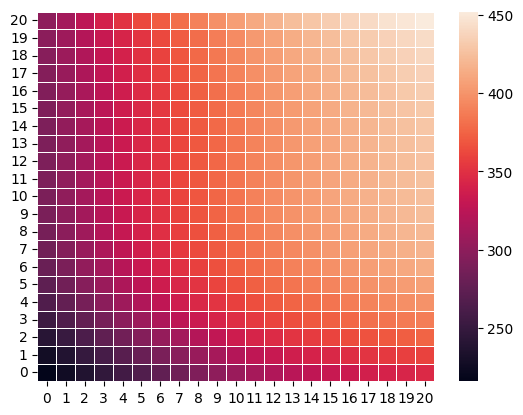

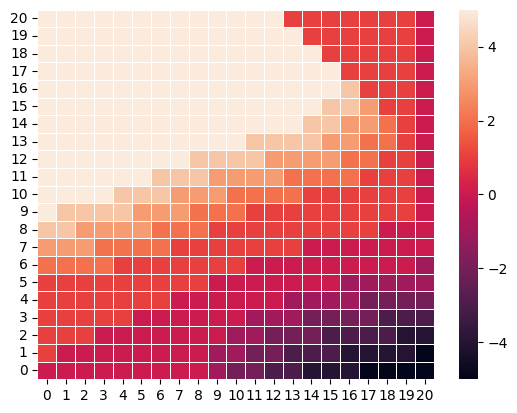

δ = 4.5684130317891912

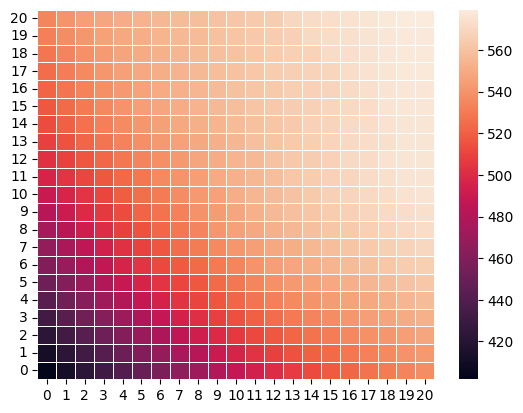

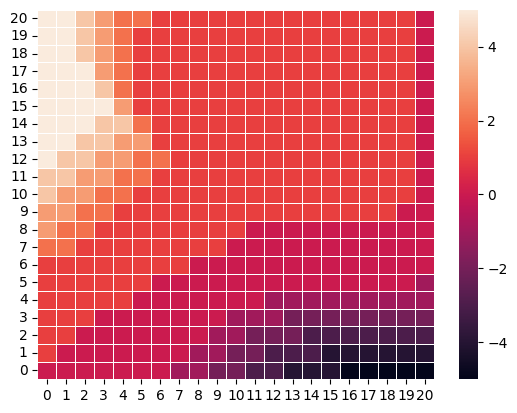

δ = 0.4666922354289227

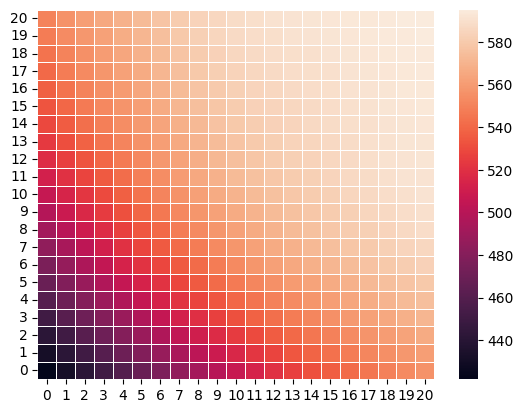

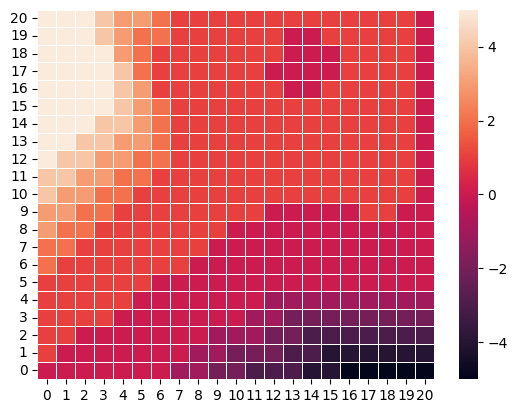

δ = 0.04375333916385671

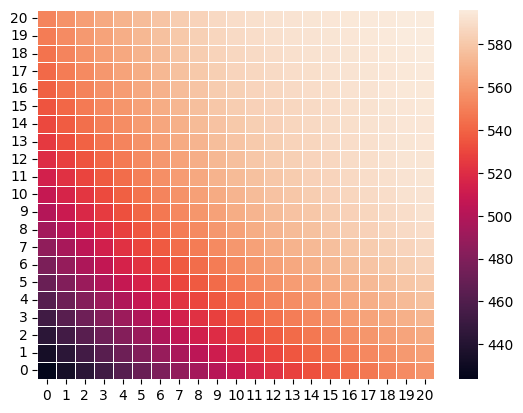

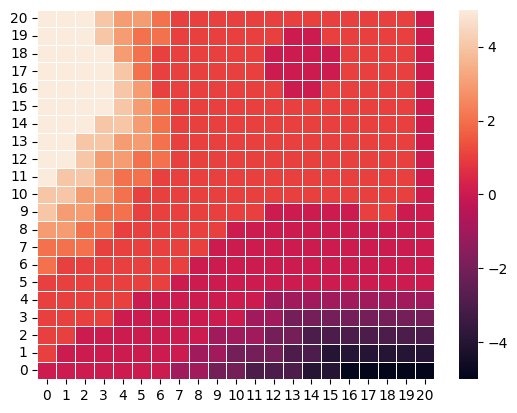

δ = 0.0041463560754664296

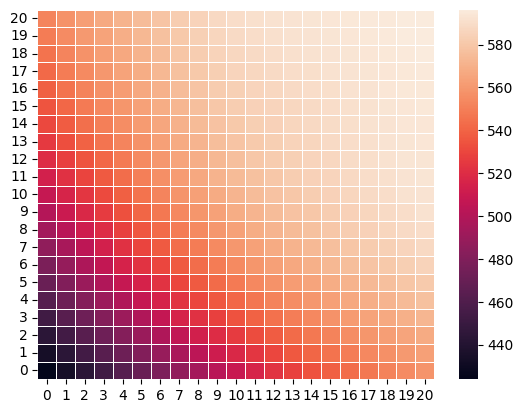

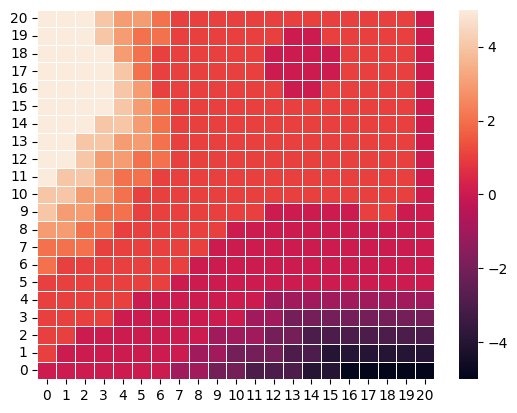

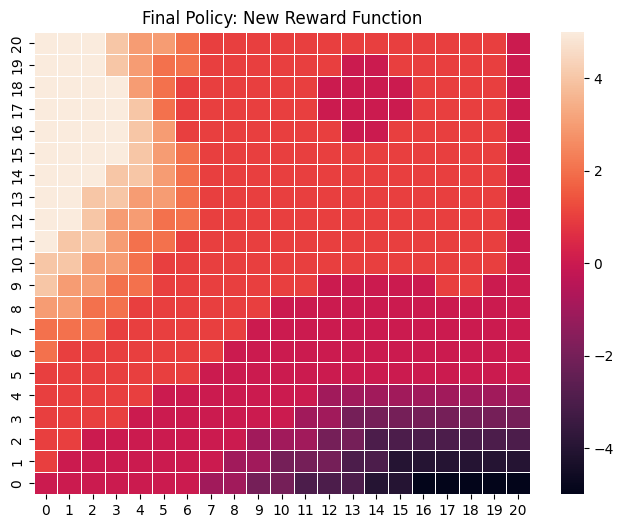

In [124]:
while(True):
    policy_evaluation(expected_reward_new)
    ρ = policy_improvement(expected_reward_new)
    save_value()
    save_policy()
    if ρ == True:
        break
    
plt.figure(figsize=(8, 6))
ax = sns.heatmap(policy, linewidth=0.5)
ax.invert_yaxis()
plt.title("Final Policy: New Reward Function")
plt.savefig("final_policy_new_rew.svg")
plt.show()
plt.close()

## Visualize The Two Policies Side By Side

This can only be done if the Main Loop was ran with both policies independently. This means you have to run the Main Loop twice, resetting the whole environment in between, as well as changing the policy function each time.